# Methods and Results

In [1]:
# import the libraries used for analysis

library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
## Temp cell for data wrongling, section should be attached to pre-results so do not include this cell in final project!!!!!!!!!!!

order <- c("high", "low")

dataset <- read_csv('../data/forestfires.csv') %>%
  select(wind, area) %>%
  mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
  filter(!is.na(wind) | !is.na(area)) %>%
  mutate(
    category=cut(wind, breaks=quantile(wind,c(0,1/2,1)), labels=order,include.lowest = TRUE),
    area_log10 = log10(1+ area)
  )

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Confidence Interval

# A tibble: 1 × 2
  lower_ci upper_ci
     <dbl>    <dbl>
1    -11.6     10.6


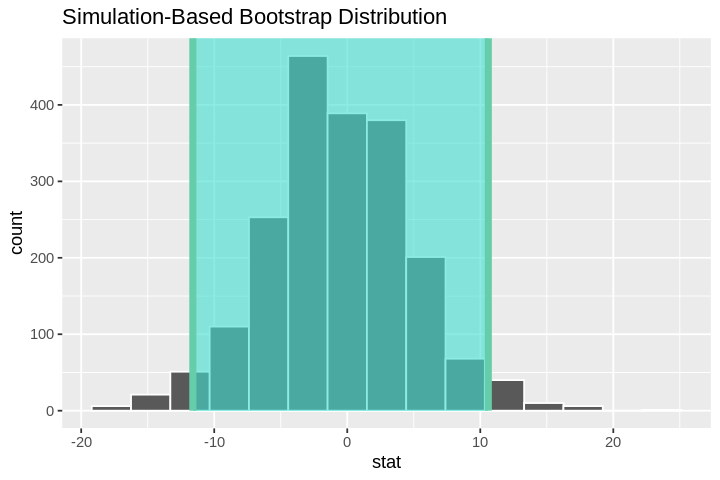

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)

# set the seed so that the randomization is consistent
set.seed(1234)

# bootstrap with 2000 replicate
bootstrap_dist_data_infer <- dataset %>%
    specify(formula = area ~ category) %>%
    generate(type = "bootstrap", reps = 2000) %>%
    calculate(stat = "diff in means", order = order) 

percentile_ci <- bootstrap_dist_data_infer	%>%
    get_ci(type = "percentile", level = 0.95)
print(percentile_ci)

# confidence interval of the difference in means
bootstrap_dist_data_infer %>%
    visualize() +
    shade_confidence_interval(endpoints = percentile_ci)

(Need to include interpretation here)

### Simulation Based Hypothesis Test

Warning message:
“Parameter values are not specified when testing that two variables are independent.”


p_value
<dbl>
0.573


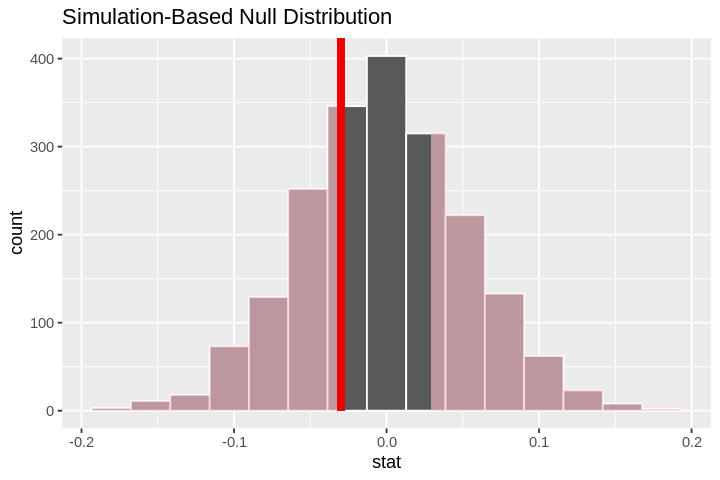

In [12]:
alpha <- 0.05

# null distribution (N0 : mu1 - mu1 = 0) of the difference in means
null_distribution_mean <- dataset %>%
  specify(formula = area_log10 ~ category) %>% 
  hypothesize(null = "independence", mu = 0) %>% 
  generate(reps = 2000, type = "permute") %>% 
  calculate(stat = "diff in means", order = order)

# calculate our sample statistic
obs_diff_means <- dataset %>% 
  specify(formula = area_log10 ~ category) %>% 
  calculate(stat = "diff in means", order = order)

# visualize into histogram and show where the p-value lies
null_distribution_mean %>%
    visualize() +
    shade_p_value(obs_diff_means, direction = "two_sided")

# calculate precise p-value of our statistic under the null model
null_distribution_mean %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")

(Interpretation Here)

### Theory Based Hypothesis Test

In [14]:
# split the category
high_cat <- filter(dataset, category == 'high')
low_cat <- filter(dataset, category == 'low')

# find the variance across both categories
var1 <- var(high_cat$area_log10)
var2 <- var(low_cat$area_log10)

# count the rows
n1 <- high_cat %>% nrow()
n2 <- low_cat %>% nrow()

# calculate degrees of freedom for populations with unequal variances
var1n1 <- (var1/n1)
var2n2 <- (var2/n2)
df <- (var1n1/var2n2)^2 / ((1/(n1-1))*var1n1^2 + (1/(n2-1))*var2n2^2)

# calculate the t-statistic
t_stat <- (obs_diff_means) / sqrt((var1/n1) + (var2/n2))

# comparing t stat to t distribution under null model and finding the p-value (multiply by 2 for two-tailed test)
p_value <- pt(t_stat$stat, df)*2

print(p_value)

[1] 0.5799658


(Interpretation Here)

### Comparison

(Interpretation Here)